In [580]:
import gensim.models
import math
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import re
import seaborn as sns
import scipy.stats as stats
import shutil

from zipfile import ZipFile
from gensim.models import KeyedVectors
from itertools import groupby  
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import cohen_kappa_score

In [581]:
flatten = lambda l: [item for sublist in l for item in sublist]

# Get the data

In [582]:
def get_patients_data(path_to_csv, columns=None, dropna=True):
    """
    gets a csv dataset into pandas keeping specified columns and dropping or keeping na's

    :param path_to_csv: str
    :param columns: list of str, columns to keep, None by default (keeps all)
    :param dropna: bool, whether to drop na's, True by default
    :return: pd.DataFrame
    """
    res = pd.read_csv(path_to_csv, index_col=0)
    if columns:
        columns = list(filter(lambda col: col in res, columns))
        if columns:
            res = res[columns]
    if dropna:
        res = res.dropna()
    return res

In [583]:
csv = "verbal_fluency_schizo.csv"
columns = ['ID', 'sex', 'diagnosis', 'age', 'education', 'TD', 'PANSS_O', 'PANSS_1', 
           'HDRS', 'Y2RS', 'animals', 'raw', 'cluster_galya', 'cluster_tanya', 'cluster_nastya']
animals = get_patients_data(csv, columns, dropna=False)
animals = animals[~pd.isnull(animals['animals'])]
animals['animals'] = animals['animals'].apply(lambda s: [x.strip() for x in s.strip().split(';')])
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,raw,cluster_galya,cluster_tanya,cluster_nastya
ID,,,,,,,,,,,,,,
S5,"1,00","1,00","30,00","16,00","15,00","42,00","85,00",NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",(0.5) зебра (0.0) лев (0.2) слон (0.0) носорог...,"зебра, лев, слон, носорог, жираф; собака, кошк...","зебра, лев, слон, носорог, жираф; собака; кошк...","зебра, лев, слон, носорог, жираф; собака, кошк..."
S6,"1,00","1,00","36,00","16,00","12,00","30,00","83,00",NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",(0.5) кошка (0.0) собака (0.0) корова (0.0) ко...,"кошка, собака, корова, коза; койот; слон, жира...","кошка, собака, корова, коза; койот; слон, жира...","кошка, собака; корова, коза; койот; слон, жира..."


In [584]:
animals['binary_diagnosis'] = animals['diagnosis'].apply(lambda x: 1 if x == '1,00' or x == '2,00' else 0)

## typing

In [585]:
for col in ['age', 'sex', 'education', 'TD', 'PANSS_O', 'PANSS_1', 'HDRS', 'Y2RS', 'diagnosis']:
    animals[col] = animals[col].apply(lambda s: float(s.replace(',', '.')) if type(s) == str else s)

In [586]:
animals.tail(2)

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,raw,cluster_galya,cluster_tanya,cluster_nastya,binary_diagnosis
ID,,,,,,,,,,,,,,,
C45,1.0,0.0,29.0,15.0,NaN,NaN,NaN,NaN,NaN,"[слон, собака, кошка, тигр, леопард, жираф, бе...",NaN,"слон; собака, кошка; тигр, леопард, жираф, бег...","слон; собака, кошка, тигр, леопард; жираф, бег...","слон; собака, кошка; тигр, леопард; жираф, бег...",0
C46,1.0,0.0,59.0,12.0,NaN,NaN,NaN,NaN,NaN,"[волк, собака, медведь, крокодил, медведь, кош...",NaN,"волк, собака, медведь; крокодил; медведь; кошк...","волк, собака; медведь; крокодил; медведь; кошк...",волк; собака; медведь; крокодил; медведь; кошк...,0


## extract timestamps

**TODO: fix pause - word relation, as now we omit words we don't know and suddenly nothing works**

In [587]:
def get_times(s):
    if type(s) == str:
        s = s.strip()
        s = re.sub('[а-я]+', ' ', s)
        s = s.replace('·', '')
        while '  ' in s:
            s = s.replace('  ', ' ')
        s = s.replace('(', ' ')
        s = s.replace(')', ' ')
        return [float(x) for x in s.split()]
    else:
        s

In [588]:
animals['raw'] = animals['raw'].apply(lambda s: s.strip() if type(s) == str else s)
animals['times'] = animals['raw'].apply(get_times)

In [589]:
animals['len_times'] = animals['times'].apply(lambda x: len(x) if type(x) == list else 0)
animals['len_words'] = animals['animals'].apply(lambda x: len(x) if type(x) == list else 0)
animals['diff'] = animals['len_words'] - animals['len_times']
np.unique(animals[animals['len_times'] > 0]['diff'])

array([-1,  0], dtype=int64)

In [590]:
animals['first_pause'] = animals['times'].apply(lambda l: l[0] if l else l)
animals['last_pause'] = animals['times'].apply(lambda l: l[-1] if l else l)
animals['total_pause'] = animals['times'].apply(lambda l: sum(l) if l else l)
animals['times'] = animals['times'].apply(lambda l: l[1:-1] if l else l)

## UNIQUE word num

In [591]:
animals['unique_num'] = animals['animals'].apply(lambda x: len(set(x)) if type(x) == list else 0)

## repetitions number

In [592]:
animals['repeat_num'] = animals['len_words'] - animals['unique_num']

## omit immediate repetitions from EVERYTHING

In [593]:
def omit_repeat(words):
    """
    removes immediate repetitions for a list of str
    
    :param words: list of str
    :return: list of str with immediate repetitions removed
    """
    return [i[0] for i in groupby(words)]

In [594]:
animals['animals'] = animals['animals'].apply(omit_repeat)

# Descriptive statistics

In [595]:
animals[['age', 'education', 'TD', 'PANSS_O', 'PANSS_1', 'HDRS', 'Y2RS']].apply(np.mean)

age          34.474268
education    14.895062
TD            7.666667
PANSS_O      22.361111
PANSS_1      47.694444
HDRS         27.000000
Y2RS         18.000000
dtype: float64

In [596]:
animals[['age', 'education', 'TD', 'PANSS_O', 'PANSS_1', 'HDRS', 'Y2RS']].apply(np.std)

age          16.842849
education     2.517490
TD            3.894440
PANSS_O       9.484352
PANSS_1      21.400700
HDRS         13.140269
Y2RS          3.000000
dtype: float64

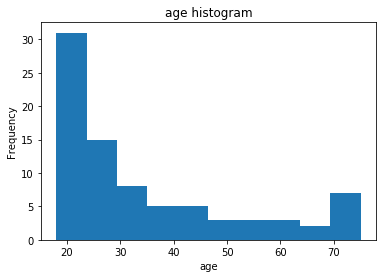

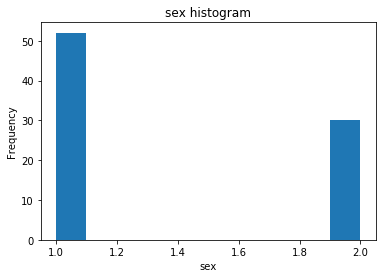

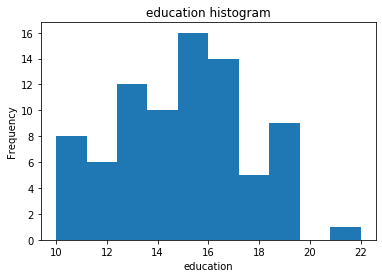

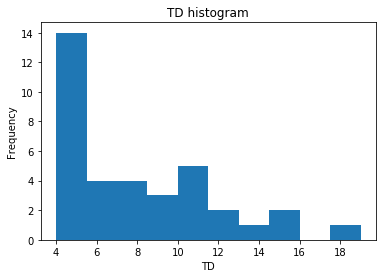

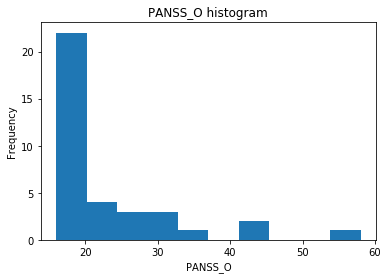

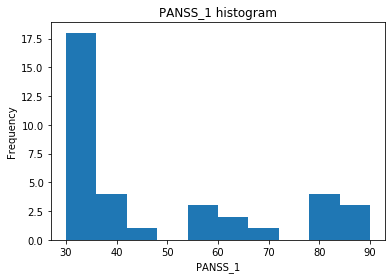

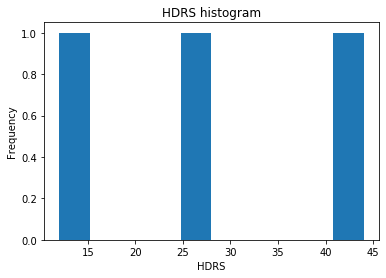

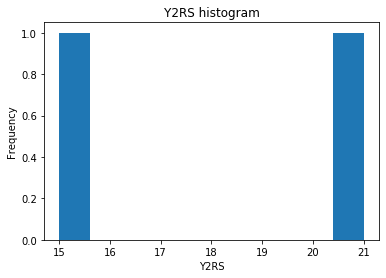

In [597]:
for col in ['age', 'sex', 'education', 'TD', 'PANSS_O', 'PANSS_1', 'HDRS', 'Y2RS']:
    animals.plot(y=col, kind='hist', legend=False)
    plt.xlabel(col)
    plt.title(f'{col} histogram');

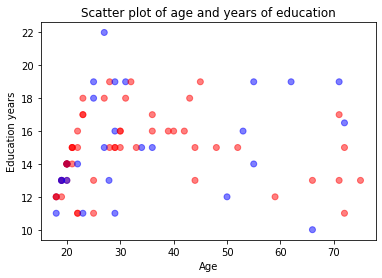

In [598]:
plt.scatter(animals['age'], animals['education'], 
            c=['red' if x == 1.0 else 'blue' for x in animals['sex']], alpha=0.5)
plt.ylabel('Education years')
plt.xlabel('Age')
plt.title('Scatter plot of age and years of education');

In [599]:
animals['sex'].value_counts()

1.0    52
2.0    30
Name: sex, dtype: int64

In [600]:
animals.groupby(['binary_diagnosis'])['sex'].value_counts()

binary_diagnosis  sex
0                 1.0    42
                  2.0    25
1                 1.0    10
                  2.0     5
Name: sex, dtype: int64

In [601]:
animals.groupby(['binary_diagnosis'])['sex'].value_counts(normalize=True)

binary_diagnosis  sex
0                 1.0    0.626866
                  2.0    0.373134
1                 1.0    0.666667
                  2.0    0.333333
Name: sex, dtype: float64

In [602]:
animals['diagnosis'].value_counts()

0.0    62
1.0    10
3.0     5
2.0     5
Name: diagnosis, dtype: int64

**let us chect the normality**

In [603]:
animals[['age', 'education', 'TD', 'PANSS_O', 'PANSS_1']].apply(lambda l: stats.normaltest(l, nan_policy='omit')[1])

age          0.001114
education    0.369871
TD           0.045804
PANSS_O      0.000001
PANSS_1      0.032625
dtype: float64

**ok, most of it is definetiley not normally distributed, and we have seen that**<br>
- age
- TD
- PANSS

oh, well, let us use non-parametric correlations, like Spermans

In [604]:
stats.spearmanr(animals['age'], animals['education'], nan_policy='omit')

SpearmanrResult(correlation=0.33057061116366776, pvalue=0.0025772913002528835)

In [605]:
def display_test(df, columns_to_test, target_column, test, nan_policy='omit', stat_name='x'):
    """
    shows a stats test result for a given list of columns with a key column
    
    :param df: pd.DataFrame
    :param columns_to_test: list of str, column names
    :param target_column: str, column name to test all others against
    :param test: func, stats test taking lists as inputs and returning a tuple of float, power and significance
    :param nan_policy: str, argument for the test, optional, default 'omit'
    :patam stat_name: str, the name of the test variable, optional, default 'x'
    
    :return: styled pd.DataFrame with test results
    """
    res = pd.DataFrame(columns=[stat_name, 'p', 'sig'], index=columns_to_test)

    for column in columns_to_test:
        r, p = list(test(df[target_column], df[column], nan_policy=nan_policy))
        res.loc[column] = [r, p, p<0.05]
    reject, pvalscorr = multipletests(res['p'], alpha= 0.05, method='b')[:2]
    res['bonf'], res['bonf_sig'] = pvalscorr, reject
    res = pd.DataFrame([list(res.loc[column]) for column in columns_to_test], columns=[stat_name, 'p', 'sig', 'bonf', 'bonf_sig'], index=columns_to_test)
    return res.sort_values(['p']).style.background_gradient(axis=0, cmap='Reds')

In [606]:
t_test = ['binary_diagnosis', 'sex']
corr_test = ['TD', 'PANSS_O', 'PANSS_1', 'age', 'education']

In [607]:
for col_name in t_test:
    print(col_name)
    display(display_test(animals, corr_test, col_name, stats.ttest_ind, stat_name='t'))

binary_diagnosis


,t,p,sig,bonf,bonf_sig
education,-51.9769,1.55052e-102,True,7.75261e-102,True
age,-18.3188,2.5451e-41,True,1.27255e-40,True
PANSS_O,-20.9553,3.03886e-41,True,1.51943e-40,True
PANSS_1,-19.9253,2.98054e-39,True,1.49027e-38,True
TD,-17.0627,2.05969e-33,True,1.02984e-32,True


sex


,t,p,sig,bonf,bonf_sig
education,-47.4929,1.30144e-96,True,6.50722e-96,True
age,-17.6843,1.15877e-39,True,5.79386e-39,True
PANSS_O,-19.8169,4.86558e-39,True,2.43279e-38,True
PANSS_1,-19.4252,2.89738e-38,True,1.44869e-37,True
TD,-14.2794,2.58345e-27,True,1.29173e-26,True


In [608]:
animals[corr_test].corr()

,TD,PANSS_O,PANSS_1,age,education
TD,1.000000,0.692886,0.853004,0.075529,-0.492079
PANSS_O,0.692886,1.000000,0.876144,0.085300,-0.420177
PANSS_1,0.853004,0.876144,1.000000,0.224122,-0.444563
age,0.075529,0.085300,0.224122,1.000000,0.107148
education,-0.492079,-0.420177,-0.444563,0.107148,1.000000


In [609]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [610]:
mask = calculate_pvalues(animals[corr_test]) > 0.05 

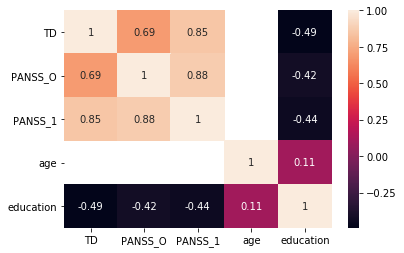

In [611]:
sns.heatmap(animals[corr_test].corr(), annot=True, mask = mask)
plt.yticks(rotation = 0)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!;

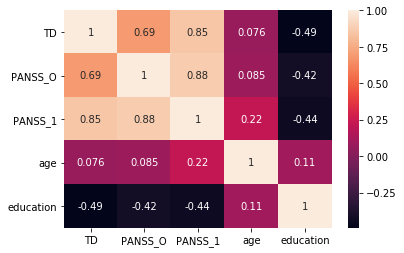

In [612]:
sns.heatmap(animals[corr_test].corr(), annot=True)
plt.yticks(rotation = 0)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!;

# Cosine similarity

## preprocess POS

In [613]:
def add_POS_tags(patient_word_list):
    """
    adds "POS tags" to words in a word list
    if single word is given, _NOUN tag is added
    if a bi-gram is given, _ADJ and _NOUN tags are added
    
    :param patient_word_list: list of str, words
    :return: list of str, words with POS tags
    """
    res = []
    for j, word in enumerate(patient_word_list):
        if word:
            if ' ' in word:
                words = word.split()
                fisrts = words[:-1]
                fisrts = ' '.join([x + '_ADJ' for x in fisrts])
                second = words[-1] + '_NOUN'
                res.append(fisrts + ' ' + second)
            else:
                res.append(word+'_NOUN')
    return res

In [614]:
animals['animals_POS'] = animals['animals'].apply(add_POS_tags)
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,...,times,len_times,len_words,diff,first_pause,last_pause,total_pause,unique_num,repeat_num,animals_POS
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,42.0,85.0,NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",...,"[0.0, 0.2, 0.0, 0.0, 0.4, 0.0, 0.3, 2.0, 1.1, ...",26,26,0,0.5,9.8,44.1,22,4,"[зебра_NOUN, лев_NOUN, слон_NOUN, носорог_NOUN..."
S6,1.0,1.0,36.0,16.0,12.0,30.0,83.0,NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",...,"[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.1, 0.0, 2.1, ...",34,33,-1,0.5,0.0,51.9,32,1,"[кошка_NOUN, собака_NOUN, корова_NOUN, коза_NO..."


## load model

In [615]:
model_zip_name = 'models/tayga_upos_skipgram_300_2_2019.zip'
with ZipFile(model_zip_name, 'r') as myzip:
    myzip.extractall('models/tmp')

model_path = 'models/tmp/model.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

wv = KeyedVectors.load('models/187/model.model')

shutil.rmtree('models/tmp/')

how do we handle multiword vectors

In [616]:
def collocation_handler(model, word, collocation_function=None):
    """
    gets a vector of a word or a bigram using a function to combine two vectors in a colloctaion
    
    :param model: gensim.Word2Vec model
    :param word: str, word or bi-gram
    :param collocation_function: function to combine two word vectors, None by default (np.mean is used)
    :return word_vector: np.ndarray, word vector
    :return not_found: int, number of words that were absent in the model
    """
    not_found = 0
    if ' ' in word:
        if not collocation_function:
            collocation_function = lambda vecs: np.mean(vecs, axis=0)
        words = word.split()
        vecs = []
        not_found = 0
        for word in words:
            if word in model:
                vecs.append(model[word])
            else:
                not_found += 1
        if len(vecs) == 0:
            word_vector = None
        elif len(vecs) == 1:
            word_vector = vecs[0]
        else:
            word_vector = collocation_function(vecs)
    else:
        if word in model:
            word_vector = model[word]
        else:
            word_vector = None
            not_found = 1
    return word_vector, not_found

In [617]:
oov_list = []
no_pos_oov_list = []

In [618]:
def cos_sim(v1, v2):
    return np.inner(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [619]:
def get_cos_sim_list(model, patient_word_list, oov_list, collocation_function=None, oov=True):
    """
    calculates pairwise cosine similarities of words or collocations in a word list

    cosine similarity for a word pair that has a collocation is calculated as
    cosine similarity between a word vector and an average of word vectors from the collocation

    :param model: gensim.word2vec model
    :param patient_word_list: list of strings, words produced by the patient
    :param oov_list: list of str, where to add oov
    :param collocation_function: function combining two word vectors in a collocation, optional default is mean
    :param oov: bool, optional (True by deafult), whether to add oov words to a global variable oov_list
    :return patient_cos_sim_list: list of float, pairwise cosine similarities
    :return not_found: int, number of words missing from the model vocabulary
    """
    patient_cos_sim_list = []
    not_found = 0
    for j, word in enumerate(patient_word_list):
        if j > 0:
            previous_word = patient_word_list[j - 1]
            word_vector, nf = collocation_handler(model, word, collocation_function)
            not_found += nf
            previous_word_vector, nf = collocation_handler(model, previous_word, collocation_function)
            not_found += nf
            if word_vector is None:
                if oov:
                    oov_list.append(word)
                else:
                    continue
            elif previous_word_vector is not None:
                patient_cos_sim_list.append(cos_sim(word_vector, previous_word_vector))
            else:
                continue
    not_found = math.ceil(not_found / 2)
    return patient_cos_sim_list, not_found

## cosine similarities of a list of words

In [620]:
animals['cos_sim_list'], animals['oov_words'] = zip(*animals['animals_POS'].map(lambda x: get_cos_sim_list(model, x, oov_list)))
animals['no_pos_cos_sim_list'], _ = zip(*animals['animals_POS'].map(lambda x: get_cos_sim_list(wv, x, no_pos_oov_list)))
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,...,diff,first_pause,last_pause,total_pause,unique_num,repeat_num,animals_POS,cos_sim_list,oov_words,no_pos_cos_sim_list
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,42.0,85.0,NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",...,0,0.5,9.8,44.1,22,4,"[зебра_NOUN, лев_NOUN, слон_NOUN, носорог_NOUN...","[0.49467045, 0.6340528, 0.7822212, 0.6697994, ...",0,"[0.25296235, 0.23456416, 0.31641218, 0.4103258..."
S6,1.0,1.0,36.0,16.0,12.0,30.0,83.0,NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",...,-1,0.5,0.0,51.9,32,1,"[кошка_NOUN, собака_NOUN, корова_NOUN, коза_NO...","[0.7347066, 0.54376155, 0.80458444, 0.40768248...",2,"[0.55340976, 0.2679423, 0.25755632, 0.09344128..."


# Cosine similrity metrics

In [621]:
animals['mean_cos_sim'] = animals['cos_sim_list'].apply(np.mean)
animals['no_pos_mean_cos_sim'] = animals['no_pos_cos_sim_list'].apply(np.mean)
animals['min_cos_sim'] = animals['cos_sim_list'].apply(np.min)
animals['no_pos_min_cos_sim'] = animals['no_pos_cos_sim_list'].apply(np.min)
animals['max_cos_sim'] = animals['cos_sim_list'].apply(np.max)
animals['no_pos_max_cos_sim'] = animals['no_pos_cos_sim_list'].apply(np.max)
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,...,animals_POS,cos_sim_list,oov_words,no_pos_cos_sim_list,mean_cos_sim,no_pos_mean_cos_sim,min_cos_sim,no_pos_min_cos_sim,max_cos_sim,no_pos_max_cos_sim
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,42.0,85.0,NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",...,"[зебра_NOUN, лев_NOUN, слон_NOUN, носорог_NOUN...","[0.49467045, 0.6340528, 0.7822212, 0.6697994, ...",0,"[0.25296235, 0.23456416, 0.31641218, 0.4103258...",0.561607,0.318295,0.285994,0.085337,0.782221,0.55341
S6,1.0,1.0,36.0,16.0,12.0,30.0,83.0,NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",...,"[кошка_NOUN, собака_NOUN, корова_NOUN, коза_NO...","[0.7347066, 0.54376155, 0.80458444, 0.40768248...",2,"[0.55340976, 0.2679423, 0.25755632, 0.09344128...",0.574240,0.269766,0.285575,-0.072894,0.804584,0.55341


In [622]:
to_corr = ['first_pause', 'total_pause', 'len_words', 
           'mean_cos_sim', 'no_pos_mean_cos_sim', 
           'oov_words', 'min_cos_sim', 'no_pos_min_cos_sim',
           'max_cos_sim', 'no_pos_max_cos_sim', 'unique_num', 'repeat_num']

In [623]:
for col_name in t_test:
    print(col_name)
    display(display_test(animals, to_corr, col_name, stats.ttest_ind, stat_name='t'))

binary_diagnosis


,t,p,sig,bonf,bonf_sig
total_pause,-52.1711,6.78744e-82,True,8.14493e-81,True
len_words,-22.6889,3.62431e-52,True,4.34917e-51,True
unique_num,-22.6613,4.21141e-52,True,5.05369e-51,True
max_cos_sim,-13.9353,1.62245e-29,True,1.94694e-28,True
no_pos_max_cos_sim,-8.74501,2.72796e-15,True,3.27355e-14,True
mean_cos_sim,-8.58379,7.17333e-15,True,8.60799e-14,True
no_pos_min_cos_sim,3.66679,0.000332664,True,0.00399197,True
min_cos_sim,-2.72076,0.00722509,True,0.0867011,False
oov_words,-2.60032,0.0101749,True,0.122098,False
repeat_num,-2.40492,0.0173034,True,0.207641,False


sex


,t,p,sig,bonf,bonf_sig
total_pause,-50.5503,2.20113e-80,True,2.64136e-79,True
no_pos_min_cos_sim,24.753,6.26698e-57,True,7.52037e-56,True
len_words,-21.3559,5.72671e-49,True,6.87205e-48,True
unique_num,-21.3012,7.78651e-49,True,9.34382e-48,True
no_pos_mean_cos_sim,20.3296,1.93638e-46,True,2.32365e-45,True
min_cos_sim,19.4452,3.25088e-44,True,3.90105e-43,True
mean_cos_sim,15.0883,1.0886e-32,True,1.30633e-31,True
no_pos_max_cos_sim,14.5654,2.96268e-31,True,3.55521e-30,True
first_pause,11.5808,5.00139e-21,True,6.00167e-20,True
max_cos_sim,10.7397,1.17484e-20,True,1.4098e-19,True


In [624]:
for col_name in corr_test:
    print(col_name)
    display(display_test(animals, to_corr, col_name, stats.spearmanr, stat_name='r'))

TD


,r,p,sig,bonf,bonf_sig
unique_num,-0.636695,2.98463e-05,True,0.000358156,True
len_words,-0.600274,0.000108782,True,0.00130539,True
total_pause,0.433673,0.00925056,True,0.111007,False
min_cos_sim,0.394648,0.0172232,True,0.206678,False
no_pos_min_cos_sim,0.312397,0.063602,False,0.763224,False
oov_words,-0.223823,0.189431,False,1,False
max_cos_sim,-0.125731,0.464981,False,1,False
no_pos_max_cos_sim,-0.12189,0.478835,False,1,False
no_pos_mean_cos_sim,0.119716,0.486773,False,1,False
repeat_num,0.107056,0.534297,False,1,False


PANSS_O


,r,p,sig,bonf,bonf_sig
unique_num,-0.581339,0.000200676,True,0.00240812,True
len_words,-0.543826,0.000607748,True,0.00729297,True
min_cos_sim,0.374922,0.0242572,True,0.291086,False
total_pause,0.344465,0.0427278,True,0.512734,False
no_pos_min_cos_sim,0.176204,0.303958,False,1,False
oov_words,-0.154665,0.367761,False,1,False
no_pos_max_cos_sim,-0.130503,0.44807,False,1,False
repeat_num,0.127472,0.458773,False,1,False
max_cos_sim,-0.106371,0.536932,False,1,False
mean_cos_sim,-0.0376111,0.827601,False,1,False


PANSS_1


,r,p,sig,bonf,bonf_sig
unique_num,-0.679561,5.17198e-06,True,6.20638e-05,True
len_words,-0.635396,3.1345e-05,True,0.00037614,True
total_pause,0.448975,0.00682163,True,0.0818596,False
min_cos_sim,0.380629,0.0220133,True,0.26416,False
oov_words,-0.226,0.185049,False,1,False
no_pos_min_cos_sim,0.214128,0.20983,False,1,False
no_pos_max_cos_sim,-0.194546,0.255545,False,1,False
max_cos_sim,-0.154029,0.369757,False,1,False
first_pause,0.138965,0.425947,False,1,False
repeat_num,0.109235,0.525961,False,1,False


age


,r,p,sig,bonf,bonf_sig
unique_num,-0.416524,9.92875e-05,True,0.00119145,True
len_words,-0.39348,0.000255084,True,0.00306101,True
min_cos_sim,0.365918,0.000722978,True,0.00867573,True
mean_cos_sim,0.186032,0.0942542,False,1,False
total_pause,0.280092,0.10317,False,1,False
max_cos_sim,-0.175641,0.11448,False,1,False
oov_words,-0.12621,0.258535,False,1,False
no_pos_min_cos_sim,0.115039,0.30341,False,1,False
first_pause,0.15632,0.369854,False,1,False
no_pos_max_cos_sim,-0.0770642,0.491354,False,1,False


education


,r,p,sig,bonf,bonf_sig
no_pos_mean_cos_sim,-0.227512,0.0410869,True,0.493043,False
first_pause,0.331792,0.0515131,False,0.618157,False
no_pos_min_cos_sim,-0.197005,0.0779335,False,0.935202,False
len_words,0.155635,0.165316,False,1,False
unique_num,0.139458,0.21435,False,1,False
repeat_num,0.0970636,0.38867,False,1,False
no_pos_max_cos_sim,-0.042566,0.705943,False,1,False
total_pause,0.0578811,0.741196,False,1,False
mean_cos_sim,0.021478,0.849059,False,1,False
max_cos_sim,0.0185461,0.869467,False,1,False


# Clustering

## threshold cutoff
cluster boundary
- median & 25th percentile in the whole dataset
- average cosine similarity of each participant


In [625]:
def threshold_cutoff(list_of_values, threshold):
    """
    finds ids of elements below a threshold and the number of them (+1)
    
    :param list_of_values: list of int or float
    :param threshold: int or float, value that elements must exceed
    :return ids: list of int, ids where value in list_of_values is below threshold
    :return cluster_num: int, number of values below threshold + 1
    """
    if type(list_of_values) != np.ndarray:
        list_of_values = np.array(list_of_values)
    ids = list(np.where(list_of_values < threshold)[0])
    cluster_num = len(ids) + 1
    return ids, cluster_num

### sharp change
cluster boudary - cosine similarity is half _(or some other factor!)_ the average distance in the current cluster

In [626]:
def sharp_change(list_of_values, factor):
    """
    finds ids of elements below a threshold and the number of them (+1)
    
    :param list_of_values: list of int or float
    :param factor: int or float, nonzero, sharpness of change
    :return ids: list of int, ids where value in list_of_values changes sharply 
                            (by a factor of factor param)
    :return cluster_num: int, number of sharp changes + 1
    """
    cluster = [list_of_values[0]]
    ids = []
    for i, value in enumerate(list_of_values):
        current_mean = np.mean(cluster)
        if value < current_mean/factor:
            ids.append(i)
            cluster = [value]
        else:
            cluster.append(value)
    cluster_num = len(ids) + 1
    return ids, cluster_num

## Apply

In [627]:
list_cos_sim_all = flatten(animals['cos_sim_list'].tolist())
median = np.median(list_cos_sim_all)
p25 = np.percentile(list_cos_sim_all, 25)
p75 = np.percentile(list_cos_sim_all, 75)
mean = np.mean(list_cos_sim_all)
print(f'mean: {mean}\n\n25th percentile: {p25}\nmedian: {median}\n75th percentile: {p75}')

mean: 0.5500710010528564

25th percentile: 0.4468058943748474
median: 0.5474388599395752
75th percentile: 0.6656894832849503


In [628]:
animals['c_cut_median'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, median)[1])
animals['c_cut_mean'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, mean)[1])
animals['c_cut_p25'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, p25)[1])
animals['c_cut_mean_local'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, np.mean(l))[1])
animals['c_sharp_1.05'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 1.05)[1])
animals['c_sharp_1.005'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 1.005)[1])
animals['c_sharp_1.00001'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 1.00001)[1])
animals['c_sharp_0.95'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 0.95)[1])
animals['c_sharp_0.8'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 0.8)[1])
animals['c_sharp_0.5'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 0.5)[1])
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,...,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.005,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,42.0,85.0,NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",...,11,12,9,13,7,7,7,9,17,24
S6,1.0,1.0,36.0,16.0,12.0,30.0,83.0,NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",...,13,13,9,13,9,9,10,11,16,30


In [629]:
no_pos_list_cos_sim_all = flatten(animals['no_pos_cos_sim_list'].tolist())
no_pos_median = np.median(no_pos_list_cos_sim_all)
no_pos_p25 = np.percentile(no_pos_list_cos_sim_all, 25)
no_pos_p75 = np.percentile(no_pos_list_cos_sim_all, 75)
no_pos_mean = np.mean(no_pos_list_cos_sim_all)
print(f'mean: {no_pos_mean}\n\n25th percentile: {no_pos_p25}\nmedian: {no_pos_median}\n75th percentile: {no_pos_p75}')

mean: 0.2683795988559723

25th percentile: 0.15609362721443176
median: 0.26794230937957764
75th percentile: 0.36841145157814026


In [630]:
animals['no_pos_c_cut_median'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_median)[1])
animals['no_pos_c_cut_mean'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_mean)[1])
animals['no_pos_c_cut_p25'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_p25)[1])
animals['no_pos_c_cut_mean_local'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, np.mean(l))[1])
animals['no_pos_c_sharp_1.05'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.05)[1])
animals['no_pos_c_sharp_1.005'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.005)[1])
animals['no_pos_c_sharp_1.00001'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.00001)[1])
animals['no_pos_c_sharp_0.95'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.95)[1])
animals['no_pos_c_sharp_0.8'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.8)[1])
animals['no_pos_c_sharp_0.5'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.5)[1])
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,...,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,42.0,85.0,NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",...,9,9,4,14,8,10,10,12,13,24
S6,1.0,1.0,36.0,16.0,12.0,30.0,83.0,NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",...,17,18,7,18,7,9,9,13,13,26


## Means

In [631]:
methods = ['c_cut_median', 'c_cut_mean', 'c_cut_p25', 'c_cut_mean_local', 
           'c_sharp_1.05', 'c_sharp_1.005', 'c_sharp_1.00001', 
           'c_sharp_0.95', 'c_sharp_0.8', 'c_sharp_0.5']
no_pos_methods = ['no_pos_' + el for el in methods]
animals.groupby(['binary_diagnosis'])[methods].apply(np.mean)

,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.005,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5
binary_diagnosis,,,,,,,,,,
0,10.373134,10.507463,5.537313,10.671642,6.985075,7.865672,7.985075,10.253731,14.358209,19.373134
1,10.400000,10.600000,6.466667,10.066667,6.066667,6.866667,7.000000,8.533333,12.133333,17.866667


In [632]:
animals.groupby(['binary_diagnosis'])[methods].apply(np.std)

,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.005,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5
binary_diagnosis,,,,,,,,,,
0,4.846404,4.841898,3.365001,3.937527,2.949791,3.090165,3.107490,3.575803,5.253859,7.243805
1,3.963164,3.963164,2.578544,3.511252,2.048306,2.334286,2.394438,2.629744,4.161196,6.427718


In [633]:
for d in [0, 1]:
    print(d)
    print(animals[animals['binary_diagnosis'] == d][methods].apply(lambda l: stats.normaltest(l, nan_policy='omit').pvalue))

0
c_cut_median        0.230985
c_cut_mean          0.323337
c_cut_p25           0.009506
c_cut_mean_local    0.744014
c_sharp_1.05        0.338557
c_sharp_1.005       0.975262
c_sharp_1.00001     0.994385
c_sharp_0.95        0.211994
c_sharp_0.8         0.933646
c_sharp_0.5         0.923415
dtype: float64
1
c_cut_median        0.596078
c_cut_mean          0.527429
c_cut_p25           0.770555
c_cut_mean_local    0.539795
c_sharp_1.05        0.585438
c_sharp_1.005       0.553708
c_sharp_1.00001     0.530307
c_sharp_0.95        0.826845
c_sharp_0.8         0.383385
c_sharp_0.5         0.873012
dtype: float64


c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [634]:
animals.groupby(['binary_diagnosis'])[no_pos_methods].apply(np.mean)

,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5
binary_diagnosis,,,,,,,,,,
0,10.701493,10.835821,5.940299,11.313433,7.835821,8.253731,8.313433,9.940299,11.686567,16.134328
1,10.600000,10.666667,5.533333,10.733333,7.000000,7.600000,7.600000,8.933333,9.933333,14.200000


In [635]:
animals.groupby(['binary_diagnosis'])[no_pos_methods].apply(np.std)

,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5
binary_diagnosis,,,,,,,,,,
0,5.151481,5.121209,3.189912,4.309687,3.308050,3.351735,3.310810,3.300297,4.260926,6.233984
1,3.979950,4.093355,2.552559,3.837823,2.129163,2.471167,2.471167,3.065217,3.678164,6.123180


In [636]:
for d in [0, 1]:
    print(d)
    print(animals[animals['binary_diagnosis'] == d][no_pos_methods].apply(lambda l: stats.normaltest(l, nan_policy='omit').pvalue))

0
no_pos_c_cut_median        0.342340
no_pos_c_cut_mean          0.342920
no_pos_c_cut_p25           0.052761
no_pos_c_cut_mean_local    0.115265
no_pos_c_sharp_1.05        0.508385
no_pos_c_sharp_1.005       0.762925
no_pos_c_sharp_1.00001     0.809281
no_pos_c_sharp_0.95        0.184637
no_pos_c_sharp_0.8         0.058403
no_pos_c_sharp_0.5         0.807675
dtype: float64
1
no_pos_c_cut_median        0.170847
no_pos_c_cut_mean          0.331681
no_pos_c_cut_p25           0.390556
no_pos_c_cut_mean_local    0.904298
no_pos_c_sharp_1.05        0.649754
no_pos_c_sharp_1.005       0.557000
no_pos_c_sharp_1.00001     0.557000
no_pos_c_sharp_0.95        0.319033
no_pos_c_sharp_0.8         0.535947
no_pos_c_sharp_0.5         0.946030
dtype: float64


## Apply tests

In [637]:
for col_name in t_test:
    print(col_name)
    display(display_test(animals, methods, col_name, stats.ttest_ind, stat_name='t'))

binary_diagnosis


,t,p,sig,bonf,bonf_sig
c_sharp_0.95,-25.0317,1.48487e-57,True,1.48487e-56,True
c_sharp_0.8,-24.0213,2.87731e-55,True,2.87731e-54,True
c_cut_mean_local,-24.0146,2.98051e-55,True,2.98051e-54,True
c_sharp_0.5,-23.8558,6.89824e-55,True,6.89824e-54,True
c_sharp_1.00001,-22.5751,6.73881e-52,True,6.73881e-51,True
c_sharp_1.005,-22.3788,1.97047e-51,True,1.97047e-50,True
c_sharp_1.05,-20.9112,7.02545e-48,True,7.02545e-47,True
c_cut_mean,-19.7629,5.10555e-45,True,5.10555e-44,True
c_cut_median,-19.4681,2.84465e-44,True,2.84465e-43,True
c_cut_p25,-15.1666,6.64694e-33,True,6.64694e-32,True


sex


,t,p,sig,bonf,bonf_sig
c_sharp_0.5,-22.3458,2.36228e-51,True,2.36228e-50,True
c_sharp_0.8,-21.9235,2.42159e-50,True,2.42159e-49,True
c_sharp_0.95,-21.9232,2.4252e-50,True,2.4252e-49,True
c_cut_mean_local,-21.2195,1.23241e-48,True,1.23241e-47,True
c_sharp_1.00001,-18.9867,4.80706e-43,True,4.80706e-42,True
c_sharp_1.005,-18.7642,1.79291e-42,True,1.79291e-41,True
c_cut_mean,-17.4698,4.25666e-39,True,4.25666e-38,True
c_cut_median,-17.1773,2.52889e-38,True,2.52889e-37,True
c_sharp_1.05,-17.0963,4.15116e-38,True,4.15116e-37,True
c_cut_p25,-11.8735,8.62596e-24,True,8.62596e-23,True


In [638]:
for col_name in corr_test:
    print(col_name)
    display(display_test(animals, methods, col_name, stats.spearmanr, stat_name='r'))

TD


,r,p,sig,bonf,bonf_sig
c_sharp_0.95,-0.671732,7.27561e-06,True,7.27561e-05,True
c_cut_mean_local,-0.633556,3.35843e-05,True,0.000335843,True
c_cut_median,-0.62989,3.84823e-05,True,0.000384823,True
c_cut_mean,-0.611202,7.50405e-05,True,0.000750405,True
c_sharp_0.5,-0.583546,0.000187215,True,0.00187215,True
c_sharp_1.00001,-0.578122,0.000221856,True,0.00221856,True
c_sharp_1.005,-0.568751,0.000295412,True,0.00295412,True
c_sharp_0.8,-0.559095,0.00039331,True,0.0039331,True
c_cut_p25,-0.412369,0.0124466,True,0.124466,False
c_sharp_1.05,-0.391834,0.0181074,True,0.181074,False


PANSS_O


,r,p,sig,bonf,bonf_sig
c_sharp_0.95,-0.618571,5.79639e-05,True,0.000579639,True
c_sharp_0.8,-0.560083,0.000382115,True,0.00382115,True
c_sharp_0.5,-0.51639,0.00126357,True,0.0126357,True
c_sharp_1.00001,-0.516019,0.00127561,True,0.0127561,True
c_sharp_1.005,-0.513335,0.00136576,True,0.0136576,True
c_cut_mean_local,-0.500335,0.00188646,True,0.0188646,True
c_cut_median,-0.48237,0.00288868,True,0.0288868,True
c_cut_mean,-0.456033,0.00518515,True,0.0518515,False
c_sharp_1.05,-0.393032,0.0177264,True,0.177264,False
c_cut_p25,-0.305957,0.0695625,False,0.695625,False


PANSS_1


,r,p,sig,bonf,bonf_sig
c_sharp_0.95,-0.730814,4.17223e-07,True,4.17223e-06,True
c_sharp_0.8,-0.648673,1.87952e-05,True,0.000187952,True
c_cut_mean_local,-0.628762,4.0114e-05,True,0.00040114,True
c_sharp_1.005,-0.623861,4.79607e-05,True,0.000479607,True
c_sharp_1.00001,-0.620171,5.47559e-05,True,0.000547559,True
c_sharp_0.5,-0.610751,7.62208e-05,True,0.000762208,True
c_cut_median,-0.597304,0.000120057,True,0.00120057,True
c_cut_mean,-0.577842,0.000223785,True,0.00223785,True
c_sharp_1.05,-0.489221,0.00246209,True,0.0246209,True
c_cut_p25,-0.394552,0.0172528,True,0.172528,False


age


,r,p,sig,bonf,bonf_sig
c_cut_p25,-0.387811,0.000318422,True,0.00318422,True
c_sharp_0.5,-0.354741,0.00107532,True,0.0107532,True
c_cut_mean_local,-0.353056,0.00114024,True,0.0114024,True
c_sharp_0.95,-0.351641,0.00119747,True,0.0119747,True
c_cut_mean,-0.337046,0.00195909,True,0.0195909,True
c_sharp_0.8,-0.331974,0.0023121,True,0.023121,True
c_sharp_1.005,-0.330273,0.00244265,True,0.0244265,True
c_sharp_1.05,-0.328021,0.00262569,True,0.0262569,True
c_sharp_1.00001,-0.325055,0.00288558,True,0.0288558,True
c_cut_median,-0.311821,0.00434755,True,0.0434755,True


education


,r,p,sig,bonf,bonf_sig
c_sharp_0.8,0.163136,0.145621,False,1,False
c_sharp_0.5,0.161441,0.149909,False,1,False
c_cut_mean_local,0.139803,0.213206,False,1,False
c_sharp_0.95,0.109135,0.332121,False,1,False
c_cut_median,0.0940439,0.403666,False,1,False
c_sharp_1.00001,0.093236,0.407735,False,1,False
c_sharp_1.005,0.0744278,0.509026,False,1,False
c_cut_mean,0.0695711,0.537131,False,1,False
c_sharp_1.05,0.0200325,0.859109,False,1,False
c_cut_p25,0.00898454,0.936551,False,1,False


In [639]:
for col_name in t_test:
    print(col_name)
    display(display_test(animals, no_pos_methods, col_name, stats.ttest_ind, stat_name='t'))

binary_diagnosis


,t,p,sig,bonf,bonf_sig
no_pos_c_sharp_0.95,-26.0737,7.40615e-60,True,7.40615e-59,True
no_pos_c_sharp_0.8,-23.7768,1.04892e-54,True,1.04892e-53,True
no_pos_c_cut_mean_local,-23.341,1.0712e-53,True,1.0712e-52,True
no_pos_c_sharp_1.00001,-22.4355,1.44455e-51,True,1.44455e-50,True
no_pos_c_sharp_0.5,-22.3866,1.88855e-51,True,1.88855e-50,True
no_pos_c_sharp_1.005,-22.0742,1.05251e-50,True,1.05251e-49,True
no_pos_c_sharp_1.05,-21.3192,7.03649e-49,True,7.03649e-48,True
no_pos_c_cut_mean,-19.2556,9.87729e-44,True,9.87729e-43,True
no_pos_c_cut_median,-19.0022,4.38853e-43,True,4.38853e-42,True
no_pos_c_cut_p25,-16.4388,2.36744e-36,True,2.36744e-35,True


sex


,t,p,sig,bonf,bonf_sig
no_pos_c_sharp_0.95,-22.7659,2.38426e-52,True,2.38426e-51,True
no_pos_c_sharp_0.8,-21.2129,1.2795e-48,True,1.2795e-47,True
no_pos_c_cut_mean_local,-20.7891,1.40517e-47,True,1.40517e-46,True
no_pos_c_sharp_0.5,-20.6671,2.81188e-47,True,2.81188e-46,True
no_pos_c_sharp_1.00001,-19.0419,3.47122e-43,True,3.47122e-42,True
no_pos_c_sharp_1.005,-18.7168,2.37583e-42,True,2.37583e-41,True
no_pos_c_sharp_1.05,-17.8832,3.48334e-40,True,3.48334e-39,True
no_pos_c_cut_mean,-17.0826,4.5139e-38,True,4.5139e-37,True
no_pos_c_cut_median,-16.8333,2.08072e-37,True,2.08072e-36,True
no_pos_c_cut_p25,-12.9619,8.13902e-27,True,8.13902e-26,True


In [640]:
for col_name in corr_test:
    print(col_name)
    display(display_test(animals, no_pos_methods, col_name, stats.spearmanr, stat_name='r'))

TD


,r,p,sig,bonf,bonf_sig
no_pos_c_cut_median,-0.653954,1.52305e-05,True,0.000152305,True
no_pos_c_cut_mean,-0.653123,1.5747e-05,True,0.00015747,True
no_pos_c_cut_p25,-0.572399,0.00026452,True,0.0026452,True
no_pos_c_sharp_0.8,-0.541075,0.000655874,True,0.00655874,True
no_pos_c_sharp_0.5,-0.521425,0.00110982,True,0.0110982,True
no_pos_c_sharp_1.05,-0.514908,0.00131227,True,0.0131227,True
no_pos_c_cut_mean_local,-0.50844,0.0015447,True,0.015447,True
no_pos_c_sharp_0.95,-0.46809,0.00398936,True,0.0398936,True
no_pos_c_sharp_1.005,-0.448382,0.00609475,True,0.0609475,False
no_pos_c_sharp_1.00001,-0.448382,0.00609475,True,0.0609475,False


PANSS_O


,r,p,sig,bonf,bonf_sig
no_pos_c_cut_median,-0.522848,0.00106947,True,0.0106947,True
no_pos_c_cut_mean,-0.521157,0.00111758,True,0.0111758,True
no_pos_c_sharp_0.8,-0.513444,0.001362,True,0.01362,True
no_pos_c_sharp_0.5,-0.512007,0.0014124,True,0.014124,True
no_pos_c_sharp_1.05,-0.480505,0.00301545,True,0.0301545,True
no_pos_c_cut_mean_local,-0.479147,0.00311079,True,0.0311079,True
no_pos_c_cut_p25,-0.446037,0.00639952,True,0.0639952,False
no_pos_c_sharp_0.95,-0.445533,0.00646674,True,0.0646674,False
no_pos_c_sharp_1.005,-0.42421,0.0099233,True,0.099233,False
no_pos_c_sharp_1.00001,-0.42421,0.0099233,True,0.099233,False


PANSS_1


,r,p,sig,bonf,bonf_sig
no_pos_c_sharp_0.8,-0.631256,3.65861e-05,True,0.000365861,True
no_pos_c_sharp_0.5,-0.594397,0.000132096,True,0.00132096,True
no_pos_c_sharp_1.05,-0.592186,0.000141966,True,0.00141966,True
no_pos_c_cut_median,-0.583245,0.000189002,True,0.00189002,True
no_pos_c_cut_mean,-0.579248,0.000214225,True,0.00214225,True
no_pos_c_cut_mean_local,-0.569842,0.000285852,True,0.00285852,True
no_pos_c_sharp_0.95,-0.555577,0.000435593,True,0.00435593,True
no_pos_c_sharp_1.005,-0.538415,0.000705615,True,0.00705615,True
no_pos_c_sharp_1.00001,-0.538415,0.000705615,True,0.00705615,True
no_pos_c_cut_p25,-0.471393,0.00370685,True,0.0370685,True


age


,r,p,sig,bonf,bonf_sig
no_pos_c_sharp_1.05,-0.42568,6.69341e-05,True,0.000669341,True
no_pos_c_sharp_0.5,-0.425608,6.7144e-05,True,0.00067144,True
no_pos_c_cut_mean_local,-0.419794,8.63579e-05,True,0.000863579,True
no_pos_c_sharp_1.005,-0.39678,0.000223768,True,0.00223768,True
no_pos_c_sharp_1.00001,-0.384384,0.000363417,True,0.00363417,True
no_pos_c_sharp_0.8,-0.362682,0.000812238,True,0.00812238,True
no_pos_c_sharp_0.95,-0.349301,0.00129788,True,0.0129788,True
no_pos_c_cut_mean,-0.338768,0.00185083,True,0.0185083,True
no_pos_c_cut_median,-0.329965,0.002467,True,0.02467,True
no_pos_c_cut_p25,-0.210885,0.0572011,False,0.572011,False


education


,r,p,sig,bonf,bonf_sig
no_pos_c_cut_median,0.17485,0.118466,False,1,False
no_pos_c_cut_mean,0.162503,0.147212,False,1,False
no_pos_c_cut_p25,0.154623,0.168117,False,1,False
no_pos_c_sharp_0.5,0.128595,0.252572,False,1,False
no_pos_c_sharp_0.95,0.111168,0.323137,False,1,False
no_pos_c_sharp_0.8,0.10298,0.360268,False,1,False
no_pos_c_sharp_1.00001,0.0961153,0.393342,False,1,False
no_pos_c_cut_mean_local,0.0938686,0.404546,False,1,False
no_pos_c_sharp_1.005,0.0872974,0.438371,False,1,False
no_pos_c_sharp_1.05,0.075627,0.502204,False,1,False


In [641]:
animals.to_csv('applied.csv')

In [642]:
animals.columns

Index(['sex', 'diagnosis', 'age', 'education', 'TD', 'PANSS_O', 'PANSS_1',
       'HDRS', 'Y2RS', 'animals', 'raw', 'cluster_galya', 'cluster_tanya',
       'cluster_nastya', 'binary_diagnosis', 'times', 'len_times', 'len_words',
       'diff', 'first_pause', 'last_pause', 'total_pause', 'unique_num',
       'repeat_num', 'animals_POS', 'cos_sim_list', 'oov_words',
       'no_pos_cos_sim_list', 'mean_cos_sim', 'no_pos_mean_cos_sim',
       'min_cos_sim', 'no_pos_min_cos_sim', 'max_cos_sim',
       'no_pos_max_cos_sim', 'c_cut_median', 'c_cut_mean', 'c_cut_p25',
       'c_cut_mean_local', 'c_sharp_1.05', 'c_sharp_1.005', 'c_sharp_1.00001',
       'c_sharp_0.95', 'c_sharp_0.8', 'c_sharp_0.5', 'no_pos_c_cut_median',
       'no_pos_c_cut_mean', 'no_pos_c_cut_p25', 'no_pos_c_cut_mean_local',
       'no_pos_c_sharp_1.05', 'no_pos_c_sharp_1.005', 'no_pos_c_sharp_1.00001',
       'no_pos_c_sharp_0.95', 'no_pos_c_sharp_0.8', 'no_pos_c_sharp_0.5'],
      dtype='object')

# Splits

**divide a set of words into clusters by change-indicies**

In [643]:
def get_splits(some_list, *ids):
    """
    splits a list into sublists by ids
    
    :param wordlist: list to be split
    :param ids: *ids where splits should be
    :return: lsit of lists, ssplit bu ids
    """
    ids = (0,) + tuple(data+1 for data in ids) + (len(some_list)+1,)
    lists = []
    for start, end in zip(ids, ids[1:]):
        sub = some_list[start:end]
        if sub:
            lists.append(sub)
    return lists

In [644]:
def print_splitted(list_of_lists):
    """
    prints a list of lists splitting inner lists by , and outer by ||
    
    :param list_of_lists: list of lists
    """
    list_of_lists = [map(str, l) for l in list_of_lists]
    list_of_lists = [', '.join(l) for l in list_of_lists]
    print(' || '.join(list_of_lists))

## Correct clusters

In [645]:
def splits_to_ids(list_of_lists):
    """
    gets ids of elements after which the splits are made
    
    :param list_of_lists: list of lists
    :return: list of int, ids of splits
    """
    out = []
    if len(list_of_lists) == 1:  # if no splits, as only one inner list
        return out
    else:
        current = 0
        for i, l in enumerate(list_of_lists):
            length = len(l)
            new_split_id = current + length - 1
            out.append(new_split_id)
            current = new_split_id + 1
        return out[:-1]

In [646]:
oov_list

['паназиатские_ADJ горилловые_NOUN',
 'гипопотам_NOUN',
 'додо_NOUN',
 'енот_ADJ полоскун_NOUN',
 'дегу_NOUN',
 'велоцираптор_NOUN',
 'сцинк_NOUN',
 'гипопотам_NOUN',
 'трубкозуб_NOUN',
 'капибара_NOUN',
 'альпака_NOUN',
 'дельфин_ADJ афалина_NOUN',
 'финвал_NOUN',
 'харза_NOUN',
 'окапи_NOUN',
 'антилопа_ADJ гну_NOUN',
 'алет_NOUN',
 'оцелот_NOUN',
 'капибара_NOUN',
 'альпака_NOUN',
 'трубкозуб_NOUN',
 'фламинго_NOUN',
 'вомбат_NOUN',
 'россомаха_NOUN',
 'собака_ADJ динго_NOUN']

In [647]:
def remove_POS_tags(word_list):
    """
    removes "POS tags" to words in a word list
    if single word is given, _NOUN tag is added
    if a bi-gram is given, _ADJ and _NOUN tags are added
    
    :param word_list: list of str, words
    :return: list of str, words with POS tags
    """
    res = []
    for j, word in enumerate(word_list):
        if word:
            if ' ' in word:
                first, second = word.split()
                first = first.split('_')[0]
                second = second.split('_')[0]
                res.append(first + ' ' + second)
            else:
                res.append(word.split('_')[0])
    return res

In [648]:
oov_list = remove_POS_tags(oov_list)
oov_list

['паназиатские горилловые',
 'гипопотам',
 'додо',
 'енот полоскун',
 'дегу',
 'велоцираптор',
 'сцинк',
 'гипопотам',
 'трубкозуб',
 'капибара',
 'альпака',
 'дельфин афалина',
 'финвал',
 'харза',
 'окапи',
 'антилопа гну',
 'алет',
 'оцелот',
 'капибара',
 'альпака',
 'трубкозуб',
 'фламинго',
 'вомбат',
 'россомаха',
 'собака динго']

In [649]:
animals['cluster_galya']

ID
S5     зебра, лев, слон, носорог, жираф; собака, кошк...
S6     кошка, собака, корова, коза; койот; слон, жира...
S7     обезьяна; собака, кошка; поросенок, корова; хо...
S8     крокодил, динозавр, змея; заяц, волк, лиса; ди...
S9     тигр, лев; мышь; тигр, кот, собака, терьер; му...
                             ...                        
C42           лошадь, корова, баран; слон; конь; носорог
C43    лось, кабан; кошка, собака; корова, коза, овца...
C44    кошка, собака; дельфин, кит; попугай, голубь, ...
C45    слон; собака, кошка; тигр, леопард, жираф, бег...
C46    волк, собака, медведь; крокодил; медведь; кошк...
Name: cluster_galya, Length: 82, dtype: object

In [650]:
def process_cluster_str(clustering, oov=None):
    clustering = clustering.split(';')  # separate clusters 
    clustering = [cluster.split(',') for cluster in clustering]  # separate words in a cluster
    if oov:
        clustering = [[word.strip() for word in cluster if word.strip() not in oov] for cluster in clustering]  # filter oov
        clustering = [cluster for cluster in clustering if cluster]
    else:
        clustering = [[word.strip() for word in cluster] for cluster in clustering]
    ids = splits_to_ids(clustering)
    return clustering, ids

In [651]:
process_cluster_str(animals['cluster_galya']['C44'], oov=oov_list)

([['кошка', 'собака'],
  ['дельфин', 'кит'],
  ['попугай',
   'голубь',
   'ворон',
   'сорока',
   'дрозд',
   'сова',
   'кукушка',
   'воробей',
   'тетерев',
   'страус',
   'перепел'],
  ['рысь'],
  ['енот', 'бобр', 'крот'],
  ['манул'],
  ['медведь'],
  ['амурский тигр', 'лев', 'пантера', 'ягуар']],
 [1, 3, 14, 15, 18, 19, 20])

In [652]:
process_cluster_str(animals['cluster_galya']['C44'])

([['кошка', 'собака'],
  ['дельфин', 'кит'],
  ['попугай',
   'голубь',
   'ворон',
   'сорока',
   'дрозд',
   'сова',
   'кукушка',
   'воробей',
   'тетерев',
   'страус',
   'перепел'],
  ['рысь'],
  ['енот', 'бобр', 'крот'],
  ['манул'],
  ['медведь'],
  ['собака динго'],
  ['амурский тигр', 'лев', 'пантера', 'ягуар']],
 [1, 3, 14, 15, 18, 19, 20, 21])

In [653]:
cluster_galya = animals['cluster_galya'].apply(lambda x: pd.Series(process_cluster_str(x) if not pd.isnull(x) else x, index = ['cluster_galya_splits', 'cluster_galya_ids']))
animals = pd.concat([animals, cluster_galya], sort=False, axis=1)

In [654]:
cluster_tanya = animals['cluster_tanya'].apply(lambda x: pd.Series(process_cluster_str(x) if not pd.isnull(x) else x, index = ['cluster_tanya_splits', 'cluster_tanya_ids']))
animals = pd.concat([animals, cluster_tanya], sort=False, axis=1)

In [655]:
cluster_nastya = animals['cluster_nastya'].apply(lambda x: pd.Series(process_cluster_str(x) if not pd.isnull(x) else x, index = ['cluster_nastya_splits', 'cluster_nastya_ids']))
animals = pd.concat([animals, cluster_nastya], sort=False, axis=1)

In [656]:
animals['c_num_galya'] = animals['cluster_galya_ids'].apply(lambda x: len(x) if type(x) == list else x)
animals['c_num_tanya'] = animals['cluster_tanya_ids'].apply(lambda x: len(x) if type(x) == list else x)
animals['c_num_nastya'] = animals['cluster_nastya_ids'].apply(lambda x: len(x) if type(x) == list else x)
animals.head()

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,...,no_pos_c_sharp_0.5,cluster_galya_splits,cluster_galya_ids,cluster_tanya_splits,cluster_tanya_ids,cluster_nastya_splits,cluster_nastya_ids,c_num_galya,c_num_tanya,c_num_nastya
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,42.0,85.0,NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",...,24,"[[зебра, лев, слон, носорог, жираф], [собака, ...","[4, 6, 7, 8, 14, 15, 16, 20, 21, 22]","[[зебра, лев, слон, носорог, жираф], [собака],...","[4, 5, 6, 7, 8, 14, 15, 16, 20, 21, 22, 23]","[[зебра, лев, слон, носорог, жираф], [собака, ...","[4, 6, 7, 8, 14, 15, 16, 20, 21, 22]",10,12,10
S6,1.0,1.0,36.0,16.0,12.0,30.0,83.0,NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",...,26,"[[кошка, собака, корова, коза], [койот], [слон...","[3, 4, 6, 8, 12, 13, 14, 18, 19, 20, 23, 25, 28]","[[кошка, собака, корова, коза], [койот], [слон...","[3, 4, 6, 8, 12, 13, 15, 18, 19, 20, 23, 25, 28]","[[кошка, собака], [корова, коза], [койот], [сл...","[1, 3, 4, 6, 7, 12, 13, 15, 18, 19, 20, 23, 25...",13,13,14
S7,1.0,2.0,39.0,16.0,9.0,28.0,60.0,12.0,NaN,"[обезьяна, собака, кошка, поросенок, корова, х...",...,12,"[[обезьяна], [собака, кошка], [поросенок, коро...","[0, 2, 4, 8, 11]","[[обезьяна], [собака, кошка, поросенок, корова...","[0, 4, 8, 11, 12]","[[обезьяна], [собака, кошка], [поросенок, коро...","[0, 2, 4, 8, 11]",5,5,5
S8,1.0,2.0,22.0,11.0,9.0,58.0,89.0,44.0,NaN,"[крокодил, динозавр, змея, заяц, волк, лиса, д...",...,10,"[[крокодил, динозавр, змея], [заяц, волк, лиса...","[2, 5, 6, 11, 14, 16, 17]","[[крокодил, динозавр, змея], [заяц, волк, лиса...","[2, 5, 6, 11, 14, 17]","[[крокодил], [динозавр], [змея], [заяц, волк, ...","[0, 1, 2, 5, 6, 11, 14, 16, 17]",7,6,9
S9,2.0,2.0,18.0,11.0,13.0,20.0,57.0,NaN,21.0,"[тигр, лев, мышь, тигр, кот, собака, терьер, м...",...,8,"[[тигр, лев], [мышь], [тигр, кот, собака, терь...","[1, 2, 6, 7]","[[тигр, лев], [мышь], [тигр], [кот, собака, те...","[1, 2, 3, 6, 7]","[[тигр, лев], [мышь], [тигр, кот], [собака, те...","[1, 2, 4, 6, 7]",4,5,5


In [657]:
for rater in ['galya', 'tanya', 'nastya']:
    cluster = animals[f'cluster_{rater}'].apply(lambda x: pd.Series(process_cluster_str(x, oov=oov_list) if not pd.isnull(x) else x, index = [f'cluster_{rater}_splits_oov', f'cluster_{rater}_ids_oov']))
    animals = pd.concat([animals, cluster], sort=False, axis=1)
    animals[f'c_num_{rater}_oov'] = animals[f'cluster_{rater}_ids_oov'].apply(lambda x: len(x) if type(x) == list else x)

## split positions

In [681]:
to_copy = ['cos_sim_list', 'no_pos_cos_sim_list', 'cluster_galya_ids', 'cluster_tanya_ids', 'cluster_nastya_ids', 
           'c_num_galya', 'c_num_tanya', 'c_num_nastya',
          'cluster_galya_ids_oov', 'cluster_tanya_ids_oov', 'cluster_nastya_ids_oov', 
           'c_num_galya_oov', 'c_num_tanya_oov', 'c_num_nastya_oov']
clustering = animals[to_copy].copy()

In [729]:
clustering['no_pos_c_cut_median'] = clustering['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_median)[0])
clustering['no_pos_c_cut_mean'] = clustering['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_mean)[0])
clustering['no_pos_c_cut_p25'] = clustering['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, p25)[0])
clustering['no_pos_c_cut_mean_local'] = clustering['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, np.mean(l))[0])
clustering['no_pos_c_sharp_1.005'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.005)[0])
clustering['no_pos_c_sharp_1.00001'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.00005)[0])
clustering['no_pos_c_sharp_0.95'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.95)[0])
clustering['no_pos_c_sharp_0.8'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.8)[0])
clustering['no_pos_c_sharp_0.5'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.5)[0])
clustering['no_pos_possible_splits'] = clustering['no_pos_cos_sim_list'].apply(lambda l: len(l))
clustering.head()

,cos_sim_list,no_pos_cos_sim_list,cluster_galya_ids,cluster_tanya_ids,cluster_nastya_ids,c_num_galya,c_num_tanya,c_num_nastya,cluster_galya_ids_oov,cluster_tanya_ids_oov,...,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5,no_pos_possible_splits,cluster_galya_ids_binary,cluster_tanya_ids_binary,cluster_nastya_ids_binary,correct_cut,no_pos_c_sharp_1.005
ID,,,,,,,,,,,,,,,,,,,,,
S5,"[0.49467045, 0.6340528, 0.7822212, 0.6697994, ...","[0.25296235, 0.23456416, 0.31641218, 0.4103258...","[4, 6, 7, 8, 14, 15, 16, 20, 21, 22]","[4, 5, 6, 7, 8, 14, 15, 16, 20, 21, 22, 23]","[4, 6, 7, 8, 14, 15, 16, 20, 21, 22]",10,12,10,"[4, 6, 7, 8, 14, 15, 16, 20, 21, 22]","[4, 5, 6, 7, 8, 14, 15, 16, 20, 21, 22, 23]",...,"[1, 4, 6, 8, 13, 14, 16, 19, 22]","[0, 1, 4, 6, 8, 13, 14, 16, 17, 19, 22]","[0, 1, 4, 6, 8, 12, 13, 14, 16, 17, 19, 22]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...",24,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[4, 6, 7, 8, 14, 15, 16, 20, 21, 22]","[1, 4, 6, 8, 13, 14, 16, 19, 22]"
S6,"[0.7347066, 0.54376155, 0.80458444, 0.40768248...","[0.55340976, 0.2679423, 0.25755632, 0.09344128...","[3, 4, 6, 8, 12, 13, 14, 18, 19, 20, 23, 25, 28]","[3, 4, 6, 8, 12, 13, 15, 18, 19, 20, 23, 25, 28]","[1, 3, 4, 6, 7, 12, 13, 15, 18, 19, 20, 23, 25...",13,13,14,"[3, 4, 6, 8, 12, 13, 14, 18, 19, 20, 23, 25, 28]","[3, 4, 6, 8, 12, 13, 15, 18, 19, 20, 23, 25, 28]",...,"[1, 2, 3, 4, 10, 17, 24, 25]","[0, 1, 2, 3, 4, 10, 12, 15, 17, 18, 24, 25]","[0, 1, 2, 3, 4, 10, 12, 15, 17, 18, 24, 25]","[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15...",31,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...","[3, 4, 6, 8, 12, 13, 15, 18, 19, 20, 23, 25, 28]","[1, 2, 3, 4, 10, 17, 24, 25]"
S7,"[0.4697804, 0.7347066, 0.4843274, 0.6263563, 0...","[0.29874402, 0.55340976, 0.26931575, 0.4277774...","[0, 2, 4, 8, 11]","[0, 4, 8, 11, 12]","[0, 2, 4, 8, 11]",5,5,5,"[0, 2, 4, 8, 11]","[0, 4, 8, 11, 12]",...,"[2, 4, 5, 8, 11]","[0, 2, 4, 5, 8, 11]","[0, 2, 4, 5, 8, 11, 12]","[0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12]",13,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[0, 2, 4, 8, 11]","[2, 4, 5, 8, 11]"
S8,"[0.62539405, 0.3755675, 0.4221906, 0.67135924,...","[0.3542624, 0.11625, 0.26751152, 0.08533706, 0...","[2, 5, 6, 11, 14, 16, 17]","[2, 5, 6, 11, 14, 17]","[0, 1, 2, 5, 6, 11, 14, 16, 17]",7,6,9,"[2, 5, 6, 11, 14, 16, 17]","[2, 5, 6, 11, 14, 17]",...,"[1, 3, 5, 6, 9, 13, 15, 16]","[0, 1, 3, 5, 6, 9, 13, 15, 16]","[0, 1, 3, 5, 6, 9, 13, 15, 16]","[0, 1, 3, 5, 6, 9, 13, 15, 16]",18,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[2, 5, 6, 11, 14, 16, 17]","[1, 3, 5, 6, 9, 13, 15, 16]"
S9,"[0.8116844, 0.3919313, 0.43978673, 0.5536955, ...","[0.37178648, 0.10433982, 0.3678957, 0.30158088...","[1, 2, 6, 7]","[1, 2, 3, 6, 7]","[1, 2, 4, 6, 7]",4,5,5,"[1, 2, 6, 7]","[1, 2, 3, 6, 7]",...,"[1, 5, 6, 8]","[0, 1, 5, 6, 8]","[0, 1, 5, 6, 8]","[0, 1, 3, 4, 5, 6, 8]",9,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]","[1, 2, 6, 7]","[1, 5, 6, 8]"


## Human clustering

In [660]:
human = ['cluster_galya_ids', 'cluster_tanya_ids', 'cluster_nastya_ids']

In [683]:
def ids_to_binary(ids, total):
    binary = np.zeros(total)
    binary[ids] = 1
    return binary

In [684]:
ids_to_binary(clustering['cluster_galya_ids']['S19'], clustering['no_pos_possible_splits']['S19'])

array([1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1.])

In [685]:
for col_name in human:
    clustering[f"{col_name}_binary"] = clustering.apply(lambda row: ids_to_binary(row[col_name], row['no_pos_possible_splits']), axis=1)

In [691]:
clustering[['cluster_galya_ids_binary', 'cluster_tanya_ids_binary', 'cluster_nastya_ids_binary']]

,cluster_galya_ids_binary,cluster_tanya_ids_binary,cluster_nastya_ids_binary
ID,,,
S5,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
S6,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ..."
S7,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
S8,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
S9,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]"
...,...,...,...
C42,"[0.0, 0.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 1.0, 1.0, 1.0]"
C43,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
C44,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [711]:
galya_tanya = clustering[['cluster_galya_ids_binary', 'cluster_tanya_ids_binary']].apply(lambda xs: cohen_kappa_score(xs[0], xs[1]), axis=1)
print('mean:', np.mean(galya_tanya))
print('max:', np.max(galya_tanya))
print('max ID:', list(galya_tanya[galya_tanya == np.max(galya_tanya)].index))
print('min:', np.min(galya_tanya))
print('min ID:', list(galya_tanya[galya_tanya == np.min(galya_tanya)].index))

mean: 0.6817259244729864
max: 1.0
max ID: ['H5', 'H19', 'C1', 'C4', 'C5', 'C6', 'C7', 'C11', 'C21', 'C23', 'C42']
min: -0.33333333333333326
min ID: ['C35']


In [712]:
galya_nastya = clustering[['cluster_galya_ids_binary', 'cluster_nastya_ids_binary']].apply(lambda xs: cohen_kappa_score(xs[0], xs[1]), axis=1)
print('mean:', np.mean(galya_nastya))
print('max:', np.max(galya_nastya))
print('max ID:', list(galya_nastya[galya_nastya == np.max(galya_nastya)].index))
print('min:', np.min(galya_nastya))
print('min ID:', list(galya_nastya[galya_nastya == np.min(galya_nastya)].index))

mean: 0.7486753945857453
max: 1.0
max ID: ['S5', 'S7', 'S11', 'H5', 'C2', 'C4', 'C7', 'C12', 'C17', 'C34', 'C35', 'C36', 'C38', 'C42']
min: 0.0
min ID: ['H4', 'H14']


In [713]:
tanya_nastya = clustering[['cluster_tanya_ids_binary', 'cluster_nastya_ids_binary']].apply(lambda xs: cohen_kappa_score(xs[0], xs[1]), axis=1)
print('mean:', np.mean(tanya_nastya))
print('max:', np.max(tanya_nastya))
print('max ID:', list(tanya_nastya[tanya_nastya == np.max(tanya_nastya)].index))
print('min:', np.min(tanya_nastya))
print('min ID:', list(tanya_nastya[tanya_nastya == np.min(tanya_nastya)].index))

mean: 0.6664693395096247
max: 1.0
max ID: ['H5', 'H18', 'C4', 'C7', 'C10', 'C30', 'C33', 'C42']
min: -0.33333333333333326
min ID: ['C35']


**we have substatntial agreement (>0.61)**

### Gold standard (what at least two of the three agree on)

In [720]:
confidence_splits = clustering[['cluster_galya_ids_binary', 'cluster_tanya_ids_binary', 'cluster_nastya_ids_binary']].apply(np.sum, axis=1)
confidence_splits

ID
S5     [0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 3.0, 3.0, 3.0, ...
S6     [0.0, 1.0, 0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, ...
S7     [3.0, 0.0, 2.0, 0.0, 3.0, 0.0, 0.0, 0.0, 3.0, ...
S8     [1.0, 1.0, 3.0, 0.0, 0.0, 3.0, 3.0, 0.0, 0.0, ...
S9         [0.0, 3.0, 3.0, 1.0, 1.0, 0.0, 3.0, 3.0, 0.0]
                             ...                        
C42                            [0.0, 0.0, 3.0, 3.0, 3.0]
C43    [0.0, 3.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...
C44    [0.0, 3.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
C45    [3.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0, ...
C46    [1.0, 2.0, 3.0, 3.0, 3.0, 2.0, 3.0, 1.0, 3.0, ...
Length: 82, dtype: object

In [722]:
gold_standard = confidence_splits.apply(lambda ls: np.where(ls>1)[0])
gold_standard

ID
S5                 [4, 6, 7, 8, 14, 15, 16, 20, 21, 22]
S6     [3, 4, 6, 8, 12, 13, 15, 18, 19, 20, 23, 25, 28]
S7                                     [0, 2, 4, 8, 11]
S8                            [2, 5, 6, 11, 14, 16, 17]
S9                                         [1, 2, 6, 7]
                             ...                       
C42                                           [2, 3, 4]
C43                  [1, 3, 11, 14, 15, 16, 17, 18, 19]
C44                      [1, 3, 14, 15, 18, 19, 20, 21]
C45            [0, 2, 4, 7, 10, 12, 13, 18, 19, 20, 21]
C46               [1, 2, 3, 4, 5, 6, 8, 12, 13, 17, 18]
Length: 82, dtype: object

In [723]:
clustering['correct_cut'] = gold_standard

In [734]:
animals['correct_c_num'] = clustering['correct_cut'].apply(len)

## Correlate correct cluster number

In [736]:
for col_name in t_test:
    print(col_name)
    display(display_test(animals, ['correct_c_num', 'c_num_tanya', 'c_num_galya', 'c_num_nastya'], col_name, stats.ttest_ind, stat_name='t'))

binary_diagnosis


,t,p,sig,bonf,bonf_sig
correct_c_num,-20.1847,4.45342e-46,True,1.78137e-45,True
c_num_tanya,-19.4641,2.91228e-44,True,1.16491e-43,True
c_num_galya,-17.8842,3.46347e-40,True,1.38539e-39,True
c_num_nastya,-17.0209,6.58306e-38,True,2.63322e-37,True


sex


,t,p,sig,bonf,bonf_sig
correct_c_num,-17.1539,2.91756e-38,True,1.16703e-37,True
c_num_tanya,-16.6493,6.45687e-37,True,2.58275e-36,True
c_num_galya,-15.0526,1.36318e-32,True,5.45271e-32,True
c_num_nastya,-14.8024,6.6103e-32,True,2.64412e-31,True


In [739]:
display_test(animals, no_pos_methods, 'correct_c_num', stats.spearmanr, stat_name='r')

,r,p,sig,bonf,bonf_sig
no_pos_c_cut_median,0.840963,4.82829e-23,True,4.82829e-22,True
no_pos_c_cut_mean,0.837697,1.01791e-22,True,1.01791e-21,True
no_pos_c_cut_mean_local,0.770766,2.48997e-17,True,2.48997e-16,True
no_pos_c_sharp_0.5,0.688048,9.21796e-13,True,9.21796e-12,True
no_pos_c_sharp_0.8,0.678293,2.53942e-12,True,2.53942e-11,True
no_pos_c_sharp_1.00001,0.642821,7.46015e-11,True,7.46015e-10,True
no_pos_c_sharp_1.005,0.642235,7.85979e-11,True,7.85979e-10,True
no_pos_c_sharp_0.95,0.636921,1.255e-10,True,1.255e-09,True
no_pos_c_cut_p25,0.632073,1.90851e-10,True,1.90851e-09,True
no_pos_c_sharp_1.05,0.595347,3.65268e-09,True,3.65268e-08,True


## Metrics

In [79]:
def get_metrics(correct_splits_list, predicted_splits_list, total_splits_num):
    """
    gets accuracy, precision, recall and f-measure of two lists of entries
    
    :param predicted_splits_list: list, correct members
    :param predicted_list: list, predicted members
    :param total_splits_num: int, maximum of possible splits
    :return a: float, accuracy
    :return p: float, precision
    :return r: float, recall
    :return f1: float, f1-measure
    """
    cor = set(correct_splits_list)
    pred = set(predicted_splits_list)
    tp = len(cor.intersection(pred))
    tn = total_splits_num - len(cor)
    fp = len(pred) - tp
    fn = len(cor) - tp
    a = (tp + tn) / total_splits_num
    if not pred:
        p = 0
    else:
        p = tp / len(pred)
    if not cor:
        r = 0
    else:
        r = tp / len(cor)
    if not p + r:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    return a, p, r, f1

In [726]:
def get_average_metrics(df, correct_col, predicted_col, total_length_col):
    """
    calculates average accuracy, precision, recall and f1-measure for a df with lists of entries
    
    :param df: pandas DataFrame, to search in
    :param correct_col: str, column name with lists of correct entries
    :param predicted_col: str, column name with lists of predicted entries
    :param total_length_col: str, column name with ints (numbers of posssible entries)
    :return a: float, mean accuracy
    :return p: float, mean precision
    :return r: float, mean recall
    :return f1: float, mean f1-measure
    """
    m = []
    for i in clustering.index:
         m.append(get_metrics(clustering.loc[i][correct_col], 
                                   clustering.loc[i][predicted_col], 
                                   clustering.loc[i][total_length_col]))
    return np.mean(m, axis=0)

In [732]:
no_pos_metrics_df = pd.DataFrame(index=no_pos_methods, columns=['accuracy', 'precision', 'recall', 'f1-measure'])
for method in no_pos_methods:
    no_pos_metrics_df.loc[method] = get_average_metrics(clustering, 'correct_cut', method, 'no_pos_possible_splits')
no_pos_df = pd.DataFrame([list(no_pos_metrics_df.loc[metric]) for metric in no_pos_methods], index = no_pos_methods, columns = ['accuracy', 'precision', 'recall', 'f1-measure'])
no_pos_df['f-weighted'] = (1 + 0.25) * no_pos_df['precision'] * no_pos_df['recall'] / (0.25 * no_pos_df['precision'] + no_pos_df['recall'])
no_pos_df.style.background_gradient(axis=0, cmap='Reds')

,accuracy,precision,recall,f1-measure,f-weighted
no_pos_c_cut_median,0.857244,0.583698,0.663215,0.6092,0.598038
no_pos_c_cut_mean,0.860329,0.577413,0.672115,0.609131,0.594156
no_pos_c_cut_p25,0.984286,0.48552,0.96096,0.630395,0.538838
no_pos_c_cut_mean_local,0.870677,0.579296,0.700564,0.617952,0.600071
no_pos_c_sharp_1.05,0.768002,0.591162,0.477407,0.508296,0.564271
no_pos_c_sharp_1.005,0.781846,0.590945,0.506484,0.527609,0.571872
no_pos_c_sharp_1.00001,0.783925,0.589566,0.511149,0.52985,0.572015
no_pos_c_sharp_0.95,0.825718,0.564965,0.597405,0.561651,0.571168
no_pos_c_sharp_0.8,0.853405,0.538968,0.661439,0.575358,0.559695
no_pos_c_sharp_0.5,0.924536,0.475874,0.819789,0.584178,0.519458


# time - similarity

In [372]:
animals['len_times'] = animals['times'].apply(lambda x: len(x) if type(x) == list else 0)
animals['len_sims'] = animals['cos_sim_list'].apply(lambda x: len(x) if type(x) == list else 0)
animals['diff'] = animals['len_words'] - animals['len_sims']
animals[animals['len_times'] > 0]['diff']

ID
S5      2
S6      4
S7      1
S8      1
S9      1
S11     1
S12     3
S13     2
S14     1
S15     2
S16     1
S17     2
S19     4
S20     1
H1      1
H2      1
H3      1
H4      3
H5      4
H6      5
H7      1
H8      3
H9      3
H10     3
H11     1
H12     1
H13     2
H14     2
H15     1
H16     1
H17    12
H18     1
H19     1
H20     3
H21     5
Name: diff, dtype: int64

In [ ]:
animals['time_sim'] = animals.apply(lambda row: stats.spearmanr(row['times'], row['cos_sim_list']) if row['times'] else np.nan, axis=1)